In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchvision import models
from torchinfo import summary

import numpy as np
from numpy import linalg as LA
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

def load_train_img(file_path):
    with open(file_path) as f:
        lines = f.readlines()
    imgs, labels = [], []
    target_size=(128, 128)
    print('Total train images:', len(lines))
    for i in tqdm(range(len(lines)), desc="Loading images"):
    # for i in tqdm(range(100), desc="Loading images"):
        fn, label = lines[i].strip().split(' ')
        im1 = cv2.imread(fn)
        # 如果需要進行影像處理，請在這裡添加相應的處理步驟
        im1 = cv2.resize(im1, target_size)
        # 轉換成 PyTorch Tensor
        im1_tensor = torch.from_numpy(im1.transpose(2, 0, 1))  # 把channel 移到最前面

        imgs.append(im1_tensor) 
        labels.append(int(label))

    imgs_tensor = torch.stack(imgs)  # 將列表中的 Tensor 堆疊成一個整體 Tensor
    labels_tensor = torch.tensor(labels)

    return imgs_tensor, labels_tensor

def load_img(f):
    f=open(f)
    lines=f.readlines()
    imgs, labels=[], []
    target_size=(128, 128)
    print('total images:', len(lines))
    for i in tqdm(range(len(lines)), desc="Loading images"):
    # for i in tqdm(range(100), desc="Loading images"):
        fn, label = lines[i].split(' ')
        
        # 原圖
        im1=cv2.imread(fn)
        im1 = cv2.resize(im1, target_size)
        # 轉換成 PyTorch Tensor
        im1_tensor = torch.from_numpy(im1.transpose(2, 0, 1)) # 把channel 移到最前面

        imgs.append(im1_tensor) 
        labels.append(int(label))

    imgs_tensor = torch.stack(imgs)
    labels_tensor = torch.tensor(labels)

    return imgs_tensor, labels_tensor

x, y = load_train_img('train.txt')
val_x, val_y = load_img('val.txt')
tx, ty = load_img('test.txt')

Total train images: 63325


Loading images: 100%|██████████| 63325/63325 [00:23<00:00, 2752.58it/s]


total images: 450


Loading images: 100%|██████████| 450/450 [00:00<00:00, 2838.40it/s]


total images: 450


Loading images: 100%|██████████| 450/450 [00:00<00:00, 2847.13it/s]


In [3]:
y_tensor = torch.nn.functional.one_hot(y, num_classes=50)
val_y_tensor = torch.nn.functional.one_hot(val_y, num_classes=50)
test_y_tensor = torch.nn.functional.one_hot(ty, num_classes=50)
train_dataset = TensorDataset(x, y_tensor)
val_dataset = TensorDataset(val_x, val_y_tensor)
test_dataset = TensorDataset(tx, test_y_tensor)

batch_size = 128  
shuffle = True 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)


In [4]:
class attention2d(nn.Module):
    def __init__(self, in_planes, ratios, K, temperature, init_weight=True):
        super(attention2d, self).__init__()
        assert temperature%3==1
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        if in_planes!=3:
            hidden_planes = int(in_planes*ratios)+1
        else:
            hidden_planes = K
        self.fc1 = nn.Conv2d(in_planes, hidden_planes, 1, bias=False)
        # self.bn = nn.BatchNorm2d(hidden_planes)
        self.fc2 = nn.Conv2d(hidden_planes, K, 1, bias=True)
        self.temperature = temperature
        if init_weight:
            self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            if isinstance(m ,nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def updata_temperature(self):
        if self.temperature!=1:
            self.temperature -=3
            print('Change temperature to:', str(self.temperature))


    def forward(self, x):
        x = self.avgpool(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x).view(x.size(0), -1)
        return F.softmax(x/self.temperature, 1)


class Dynamic_conv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, ratio=0.25, stride=1, padding=0, dilation=1, groups=1, bias=True, K=4,temperature=34, init_weight=True):
        super(Dynamic_conv2d, self).__init__()
        assert in_planes%groups==0
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias
        self.K = K
        self.attention = attention2d(in_planes, ratio, K, temperature)

        self.weight = nn.Parameter(torch.randn(K, out_planes, in_planes//groups, kernel_size, kernel_size), requires_grad=True)
        if bias:
            self.bias = nn.Parameter(torch.zeros(K, out_planes))
        else:
            self.bias = None
        if init_weight:
            self._initialize_weights()

        #TODO 初始化
    def _initialize_weights(self):
        for i in range(self.K):
            nn.init.kaiming_uniform_(self.weight[i])


    def update_temperature(self):
        self.attention.updata_temperature()

    def forward(self, x):
        softmax_attention = self.attention(x)
        batch_size, in_planes, height, width = x.size()
        x = x.view(1, -1, height, width)
        weight = self.weight.view(self.K, -1)

        aggregate_weight = torch.mm(softmax_attention, weight).view(batch_size*self.out_planes, self.in_planes//self.groups, self.kernel_size, self.kernel_size)
        if self.bias is not None:
            aggregate_bias = torch.mm(softmax_attention, self.bias).view(-1)
            output = F.conv2d(x, weight=aggregate_weight, bias=aggregate_bias, stride=self.stride, padding=self.padding,
                              dilation=self.dilation, groups=self.groups*batch_size)
        else:
            output = F.conv2d(x, weight=aggregate_weight, bias=None, stride=self.stride, padding=self.padding,
                              dilation=self.dilation, groups=self.groups * batch_size)

        output = output.view(batch_size, self.out_planes, output.size(-2), output.size(-1))
        return output

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = Dynamic_conv2d(in_planes=3, out_planes=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = Dynamic_conv2d(in_planes=32, out_planes=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = Dynamic_conv2d(in_planes=64, out_planes=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = Dynamic_conv2d(in_planes=128, out_planes=256, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 50) 
        # self.fc2 = nn.Linear(512, 50) 

        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = self.flatten(x)
        # x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1(x)
        
        return x

In [6]:
model = CNNModel()
num_classes = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Dynamic_conv2d(
    (attention): attention2d(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (fc2): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv2): Dynamic_conv2d(
    (attention): attention2d(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(32, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (fc2): Conv2d(9, 4, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv3): Dynamic_conv2d(
    (attention): attention2d(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(64, 17, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (fc2): Conv2d(17, 4, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv4): Dynamic_conv2d(
    (attention): attention2d(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(128, 33, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (fc2): Conv2d(33, 4, kernel_size=(1, 1), str

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Dynamic_conv2d: 1-1                    3,584
│    └─attention2d: 2-1                  --
│    │    └─AdaptiveAvgPool2d: 3-1       --
│    │    └─Conv2d: 3-2                  12
│    │    └─Conv2d: 3-3                  20
├─Dynamic_conv2d: 1-2                    73,984
│    └─attention2d: 2-2                  --
│    │    └─AdaptiveAvgPool2d: 3-4       --
│    │    └─Conv2d: 3-5                  288
│    │    └─Conv2d: 3-6                  40
├─Dynamic_conv2d: 1-3                    295,424
│    └─attention2d: 2-3                  --
│    │    └─AdaptiveAvgPool2d: 3-7       --
│    │    └─Conv2d: 3-8                  1,088
│    │    └─Conv2d: 3-9                  72
├─Dynamic_conv2d: 1-4                    1,180,672
│    └─attention2d: 2-4                  --
│    │    └─AdaptiveAvgPool2d: 3-10      --
│    │    └─Conv2d: 3-11                 4,224
│    │    └─Conv2d: 3-12                 136


Epoch 1/10:   0%|          | 0/495 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 84.67it/s]


Epoch 1/10, Training Loss: 3.5074, Training Accuracy: 15.84%, Validation Accuracy: 23.78%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 110.39it/s]


Epoch 2/10, Training Loss: 2.6748, Training Accuracy: 27.07%, Validation Accuracy: 29.11%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 110.48it/s]


Epoch 3/10, Training Loss: 2.3487, Training Accuracy: 34.64%, Validation Accuracy: 34.00%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 107.90it/s]


Epoch 4/10, Training Loss: 2.1080, Training Accuracy: 40.89%, Validation Accuracy: 39.33%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 104.21it/s]


Epoch 5/10, Training Loss: 1.8592, Training Accuracy: 47.13%, Validation Accuracy: 37.33%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 103.41it/s]


Epoch 6/10, Training Loss: 1.6388, Training Accuracy: 52.72%, Validation Accuracy: 42.89%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 97.59it/s]


Epoch 7/10, Training Loss: 1.4312, Training Accuracy: 58.57%, Validation Accuracy: 43.11%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 105.01it/s]


Epoch 8/10, Training Loss: 1.2276, Training Accuracy: 64.06%, Validation Accuracy: 42.22%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 108.08it/s]


Epoch 9/10, Training Loss: 1.0242, Training Accuracy: 69.38%, Validation Accuracy: 44.22%


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 107.80it/s]


Epoch 10/10, Training Loss: 0.8447, Training Accuracy: 74.47%, Validation Accuracy: 46.67%


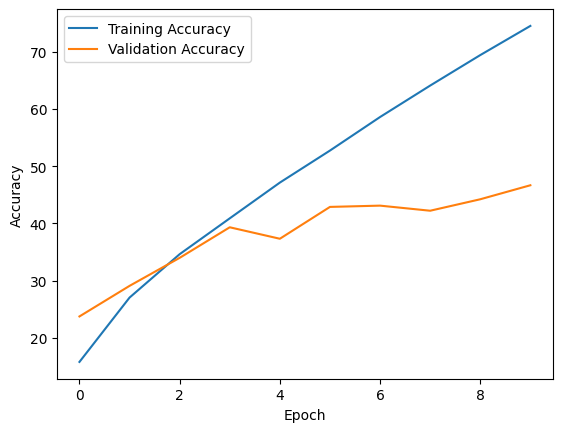

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10 

traing_acc = []
val_acc = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.float().to(device), labels.float().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        labels = labels.argmax(dim=1)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    traing_acc.append(100 * train_correct / train_total)

    epoch_loss = running_loss / len(train_loader.dataset)
    # print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            labels = labels.argmax(dim=1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()

    val_acc.append(100 * correct / total)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {100 * train_correct / train_total:.2f}%, Validation Accuracy: {100 * correct / total:.2f}%")

plt.plot(traing_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("./results/HW2-2/myModel_accuracy_plot.png")
plt.show()


In [9]:
model.eval() 
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.float().to(device), labels.float().to(device)
        labels = labels.argmax(dim=1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"test Accuracy: {accuracy:.4f}")

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 106.35it/s]

test Accuracy: 0.4844


In [10]:
torch.save(model, './model/HW2-2/myModel/myModel.pth')